In [1]:
import pandas as pd
import numpy as np
import re
import datetime

import empyrical as empy
from sklearn.metrics import accuracy_score, precision_score, explained_variance_score, mean_squared_error
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
def drawdown_from_price(price):
    if isinstance(price, pd.Series):
        return _drawdown_from_price(price)
    elif isinstance(price, pd.DataFrame):
        return price.apply(_drawdown_from_price)
    else:
        raise non_pd_error

def _drawdown_from_price(price):
    shift_max = price.copy()
    _max = price.iloc[0]
    for i, j in price.items():
        _max = max(_max, j)
        shift_max[i] = _max
    return price / shift_max - 1

def return_to_price(ret, ini=100):
    price_0 = ret.iloc[:1] * 0 + ini
    price_0.index = [0]
    price = (1+ret).cumprod() * ini
    return pd.concat([price_0, price])

def drawdown_from_return(ret, ini=100):
    price = return_to_price(ret, ini)
    return drawdown_from_price(price).iloc[1:]

def avg_drawdown(ret):
    dd = drawdown_from_return(ret)
    return dd.mean()

def empy_metric(ret):
    if isinstance(ret, pd.DataFrame):
        return ret.apply(empy_metric).T
    total_return = lambda x: (1+x).prod()-1
    met_func = [total_return, empy.annual_return, empy.sharpe_ratio, empy.annual_volatility, 
                empy.max_drawdown, avg_drawdown]
    
    met_func_names = ['total_return', 'annual_return', 'sharpe_ratio', 'annual_volatility', 
                      'max_drawdown', 'avg_drawdown',]
    
    se = pd.Series([f(ret) for f in met_func], met_func_names)
    
    se['return/maxdd'] = -se.annual_return/se.max_drawdown
    se['return/avgdd'] = -se.annual_return/se.avg_drawdown
    
    return se

In [3]:
def other_metric(ret):
    if isinstance(ret, pd.DataFrame):
        return ret.apply(other_metric).T
    
    pred_up = (ret!=0)*1
    
    highlight_ratio = pred_up.mean()
    flip_ratio = (pred_up - pred_up.shift()).abs().mean()
    
    idx_tmp = pred_up.index & true_up.index
    true_up_tmp = true_up.reindex(idx_tmp) * 1
    pred_up = pred_up.reindex(idx_tmp) * 1
    accu = accuracy_score(true_up_tmp, pred_up)
    prec = precision_score(true_up_tmp, pred_up)
    
    true_up_pct = true_ret.reindex(idx_tmp)
    true_up_pct_scaled = true_up_pct/true_up_pct.std() + 0.5
    
    mse = mean_squared_error(true_up_pct_scaled, pred_up)
    
    se = pd.Series(dtype='float64')
    
    se['highlight_ratio'] = highlight_ratio
    se['flip_ratio'] = flip_ratio
    se['accu'] = accu
    se['prec'] = prec
    se['mse'] = mse
    
    return se


In [4]:
def parse_freq(s, default_num=1, default_nth=0):
    """Split frequency
    Args:
        s (str): rebalance frequence (e.g. 2M, 10D)
        default_num (int, optional): number of period
        default_nth (int, optional): number of start point

    Returns:
        num (int): number of period
        p (str): frequency period
        nth (int): number of start point

    Raises:
        KeyError: Wrong input format of Frequency
    """
    r = re.compile('(|\d+)([A-Za-z]+)(\d+|)')
    match = r.match(s)
    if not match:
        raise KeyError('Invalid format of Frequency [{}]'.format(s))
    num, p, nth = match.groups()
    num = int(num) if len(num) > 0 else default_num
    nth = int(nth) if len(nth) > 0 else default_nth
    return num, p, nth

def group_series(dates, n_period, period, nth):
    """
    Args:
         dates (pd.Series): All trade dates in special period
        n_period (int): number of period
        period (str): frequency period
        nth (int): number of start point

    Returns:
        pd.DataFrame: the selected rebalance date
    """
    err = 'only support pandas.datetimeindex'
    assert isinstance(dates.index, pd.DatetimeIndex), err
    period_index = dates.index.to_period(period)
    if period != 'D':
        results = dates.groupby(period_index).nth(nth)
    else:
        results = dates[nth::n_period]
        n_period = 0
    if n_period > 1:
        results = results[::int(n_period)]
    return results.reset_index(drop=True)

def rebalance_date(dates, freq='M'):
    """Get rebalance date base on frequence

    Args:
        dates (Index): All trade dates in special period
        freq (str, optional): the rebalance frequence

    Returns:
        pd.DataFrame: the selected rebalance date
    """
    dates = pd.to_datetime(dates)
    dts = pd.Series(dates, index=dates).sort_values()
    if '+' in freq:
        temp = []
        for sub_freq in freq.split('+'):
            sub_dts = group_series(dts, *parse_freq(sub_freq))
            temp.append(sub_dts)
        results = pd.concat(temp).drop_duplicates().sort_values()
    else:
        results = group_series(dts, *parse_freq(freq))

    results = results.reset_index(drop=True).rename(freq)
    results_df = results.to_frame()
    results_df[freq] = pd.to_datetime(
        results_df[freq], format='%Y-%m-%d').dt.date

    return results_df[freq]

In [5]:
def plot_cumret(cumret):
    fig, ax = plt.subplots(figsize=(12,6))
    
    cm = plt.get_cmap('gist_rainbow')
    NUM_COLORS = cumret.shape[1]
    ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

    cumret.plot(ax=ax)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_yscale("log")
    plt.show()

In [6]:
csv = './data/XAU_USD.csv'
start = '1985'
end = '2021'

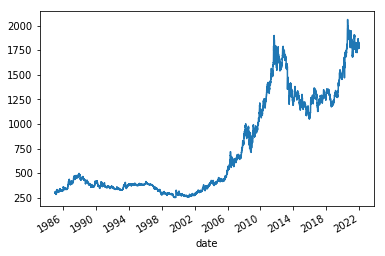

In [7]:
price = pd.read_csv(csv, index_col=0)['adj_close']
price.index = pd.to_datetime(price.index)
price[start:end].plot()

In [8]:
true_ret = price.pct_change()
true_ret = true_ret[start:end]
true_ret

date
1985-01-02   -0.009082
1985-01-03   -0.010475
1985-01-04    0.002646
1985-01-07   -0.016166
1985-01-08    0.012743
                ...   
2021-12-27    0.001543
2021-12-28   -0.003054
2021-12-29   -0.000947
2021-12-30    0.006293
2021-12-31    0.007372
Name: adj_close, Length: 9612, dtype: float64

In [9]:
true_up = (true_ret>=0)
true_up

date
1985-01-02    False
1985-01-03    False
1985-01-04     True
1985-01-07    False
1985-01-08     True
              ...  
2021-12-27     True
2021-12-28    False
2021-12-29    False
2021-12-30     True
2021-12-31     True
Name: adj_close, Length: 9612, dtype: bool

In [10]:
def gen_cycle_preds(start_preds, cycle_period, cycle_index):
    months = rebalance_date(cycle_index, cycle_period)
    pair_months = pd.concat([months, months.shift(-1)], axis=1)
    
    cycle_preds = pd.Series(start_preds, index=cycle_index)
    for idx in list(pair_months.index)[1::2]:
        row = pair_months.iloc[idx]
        s_p = row.values[0]
        e_p = row.values[1]
        if e_p is np.nan:
            cycle_preds.loc[s_p:] = not start_preds
        else:
            e_p = e_p - datetime.timedelta(days=1)
            cycle_preds.loc[s_p:e_p] = not start_preds
    cycle_preds = cycle_preds.astype(int)
    return cycle_preds

In [11]:
def gen_lookback_up_pct_pred(adj_close, roll, threshold):
    adj_close_pct_change = adj_close.shift().pct_change()
    df['count_up'] = (adj_close_pct_change>=0).shift().rolling(roll).sum()
    df['count_all'] = (adj_close_pct_change>=0).shift().rolling(roll).count()
    df['up_pct'] = df['count_up']/df['count_all']
    
    return (df['up_pct'] > threshold).astype(int)

In [12]:
def gen_lookbackN_preds(adj_close, roll):
    adj_close_pct_change = adj_close.shift().pct_change(roll)
    return (adj_close_pct_change > 0).astype(int)

In [13]:
def gen_cycle_with_conditions(start_preds, cycle_period, cycle_index, condition_df):
    months = rebalance_date(cycle_index, cycle_period)
    pair_months = pd.concat([months, months.shift(-1)], axis=1)
    
    cycle_preds = pd.Series(index=cycle_index)
    last_stage = start_preds
    for idx in list(pair_months.index):
        row = pair_months.iloc[idx]
        s_p = row.values[0]
        e_p = row.values[1]
        
        
        if e_p is np.nan:
            cycle_preds.loc[s_p:] = not start_preds
        else:
            e_p = e_p - datetime.timedelta(days=1)
            cycle_preds.loc[s_p:e_p] = not start_preds
    cycle_preds = cycle_preds.astype(int)
    return cycle_preds

In [14]:
df = pd.read_csv(csv, index_col=0)
df.index = pd.to_datetime(df.index)
adj_close = df.adj_close

In [19]:
# cycle_periods = ['M', '17D', '21D', 'Q']
# start_preds = [False, True]

cycle_periods = ['17D', '21D']
start_preds = [False, True]

cycle_index = true_ret.index

cycle_preds = pd.DataFrame(index=cycle_index)
cycle_preds['buy_and_hold'] = 1

for cp in cycle_periods:
    for s_preds in start_preds:
        cycle_preds['cycling_{}_start_{}'.format(cp, int(s_preds))] = gen_cycle_preds(s_preds, cp, cycle_index)

In [15]:
thresholds = [0.1, 0.2, 0.3, 0.4]
lookback = [5, 10, 21]
for l in lookback:
    cycle_preds['roll{}_pct'.format(l)] = gen_lookbackN_preds(adj_close, l)
    for t in thresholds:
        cycle_preds['roll{}_up_pct_exceed_{}'.format(l, t)] = gen_lookback_up_pct_pred(adj_close, l, t)
cycle_preds

,buy_and_hold,cycling_21D_start_1,roll5_pct,roll5_up_pct_exceed_0.1,roll5_up_pct_exceed_0.2,roll5_up_pct_exceed_0.3,roll5_up_pct_exceed_0.4,roll10_pct,roll10_up_pct_exceed_0.1,roll10_up_pct_exceed_0.2,roll10_up_pct_exceed_0.3,roll10_up_pct_exceed_0.4,roll21_pct,roll21_up_pct_exceed_0.1,roll21_up_pct_exceed_0.2,roll21_up_pct_exceed_0.3,roll21_up_pct_exceed_0.4
date,,,,,,,,,,,,,,,,,
1985-01-02,1,1,1,1,1,1,0,0,1,1,0,0,0,1,1,1,0
1985-01-03,1,1,0,1,1,1,1,0,1,1,1,0,0,1,1,1,1
1985-01-04,1,1,0,1,1,1,0,0,1,1,1,0,0,1,1,1,0
1985-01-07,1,1,0,1,0,0,0,0,1,1,1,0,0,1,1,1,0
1985-01-08,1,1,0,1,1,1,0,0,1,1,1,1,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,1,0,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1
2021-12-28,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2021-12-29,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [21]:
ret_cycle = cycle_preds.multiply(true_ret, 0)

In [32]:
def print_all_result(ret_df, preds, sortby='sharpe_ratio', topn=None, strategy_list_sel=None):
    
    display('{} to {}'.format(ret_df.index[0], ret_df.index[-1]))
    
    column_selected = ['annual_return', 'sharpe_ratio', 'max_drawdown', 'avg_drawdown', 'return/avgdd']
    empy_metric_tmp = empy_metric(ret_df).sort_values(sortby)
    if strategy_list_sel is None:

        strategy_list_sel = list(empy_metric_tmp.index)

        if topn is not None:
            if isinstance(topn, int):
                strategy_list_sel = strategy_list_sel[-topn:]
            else:
                strategy_list_sel = list(empy_metric_tmp.loc[topn:].index)

        if 'buy_and_hold' in strategy_list_sel:
            strategy_list_sel = [x for x in strategy_list_sel if x !='buy_and_hold']
        strategy_list_sel = ['buy_and_hold']+strategy_list_sel
    
    other_metric_tmp = other_metric(ret_df)
    
    display(other_metric_tmp.loc[strategy_list_sel[1:]].iloc[:,:5])
    display(empy_metric_tmp.loc[strategy_list_sel][column_selected])
    
    fig, ax = plt.subplots(figsize=(12,6))
    
    cm = plt.get_cmap('gist_rainbow')
    NUM_COLORS = ret_df[strategy_list_sel].shape[1]
    ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])


    (1+ret_df[strategy_list_sel]).cumprod().plot(ax=ax)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_yscale("log")
    plt.show()
    
    for case in strategy_list_sel:
        sub_pred = preds[case]
        fig, ax = plt.subplots(figsize=(12,6))
        sub_pred.loc[ret_df.index].plot(ax=ax)
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        ax.set_title(case + ' predictions')
        plt.show()
    
    return strategy_list_sel

'1985-01-02 00:00:00 to 2021-12-31 00:00:00'

,highlight_ratio,flip_ratio,accu,prec,mse
cycling_21D_start_0,0.493550,0.058579,0.493030,0.510118,1.263596
cycling_17D_start_0,0.493238,0.069400,0.490637,0.507699,1.258789
cycling_17D_start_1,0.493134,0.071273,0.495734,0.512869,1.242137
cycling_21D_start_1,0.492821,0.060452,0.493342,0.510450,1.237330


,annual_return,sharpe_ratio,max_drawdown,avg_drawdown,return/avgdd
buy_and_hold,0.047776,0.378081,-0.493126,-0.224901,0.212431
cycling_21D_start_0,0.006993,0.118372,-0.453355,-0.228851,0.030557
cycling_17D_start_0,0.013223,0.174808,-0.620421,-0.289876,0.045616
cycling_17D_start_1,0.034102,0.358828,-0.355436,-0.095012,0.358925
cycling_21D_start_1,0.040500,0.420275,-0.289186,-0.087438,0.463182


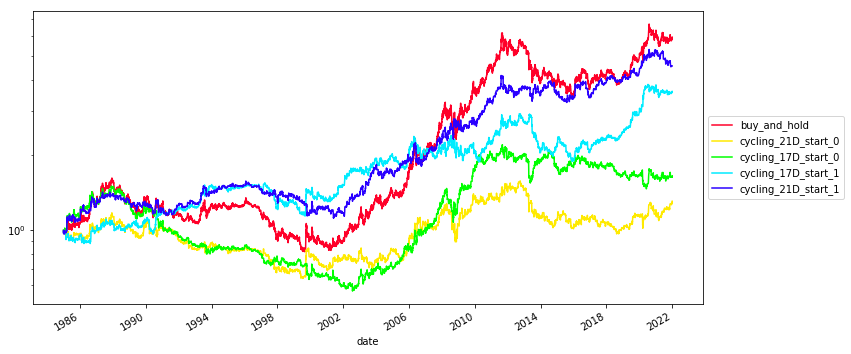

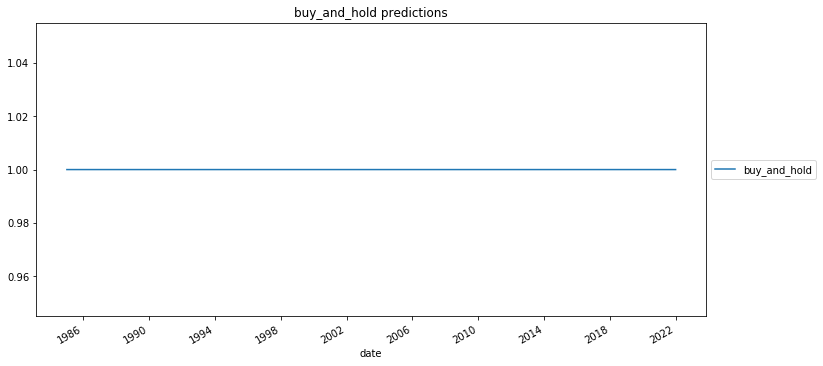

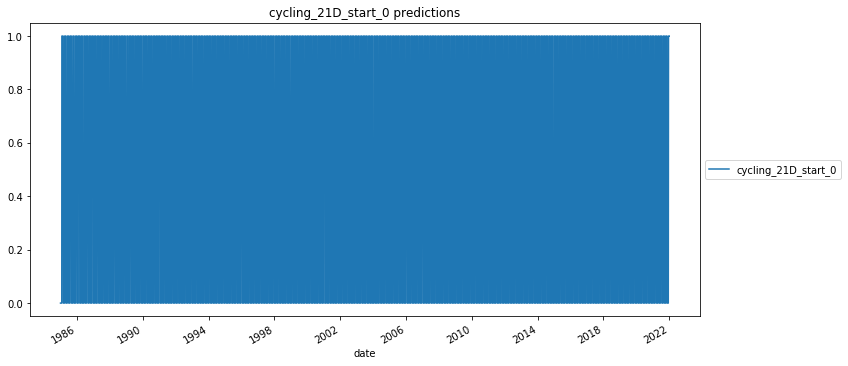

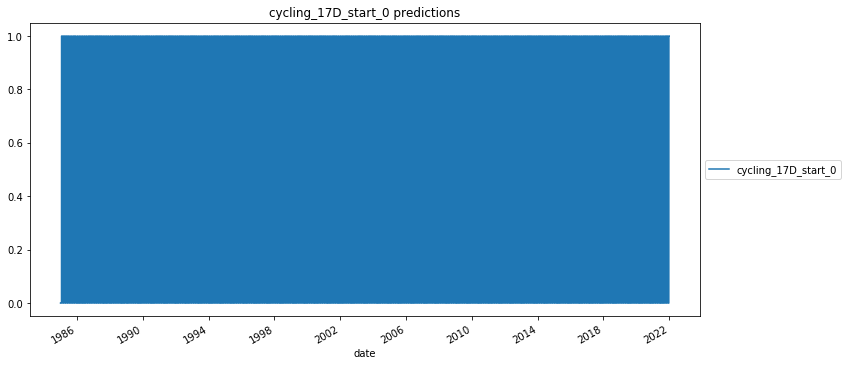

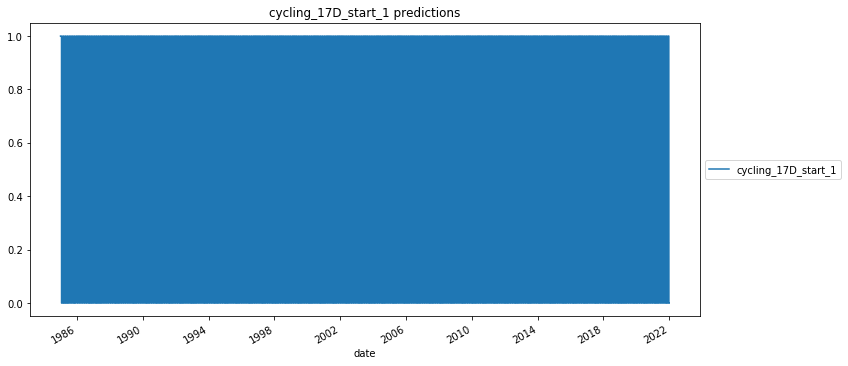

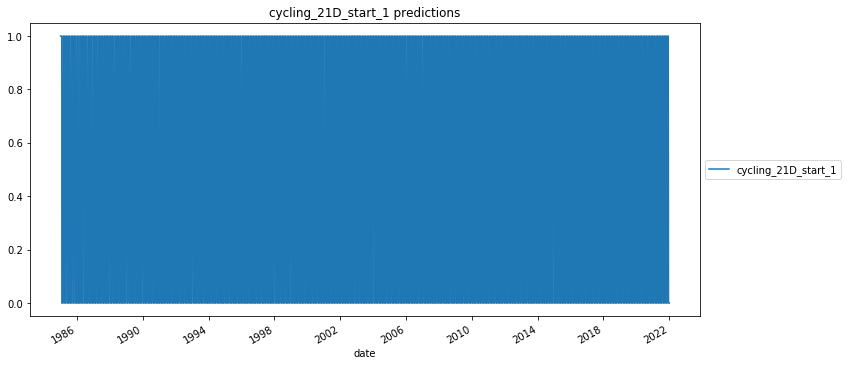

'1988-01-04 00:00:00 to 2000-12-29 00:00:00'

,highlight_ratio,flip_ratio,accu,prec,mse
cycling_21D_start_0,0.489198,0.064831,0.489494,0.476709,1.262938
cycling_17D_start_0,0.490382,0.077857,0.485351,0.472541,1.288412
cycling_17D_start_1,0.487126,0.079041,0.492157,0.479344,1.211636
cycling_21D_start_1,0.488310,0.070752,0.488014,0.475152,1.237110


,annual_return,sharpe_ratio,max_drawdown,avg_drawdown,return/avgdd
buy_and_hold,-0.042235,-0.283945,-0.481481,-0.272448,-0.155021
cycling_21D_start_0,-0.033970,-0.337314,-0.435026,-0.241526,-0.140649
cycling_17D_start_0,-0.057712,-0.642514,-0.576580,-0.390860,-0.147655
cycling_17D_start_1,0.016425,0.226499,-0.265479,-0.064452,0.254843
cycling_21D_start_1,-0.008555,-0.057282,-0.275052,-0.098676,-0.086703


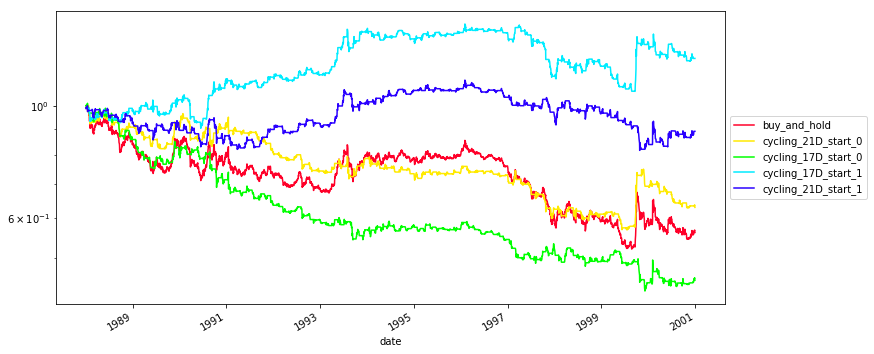

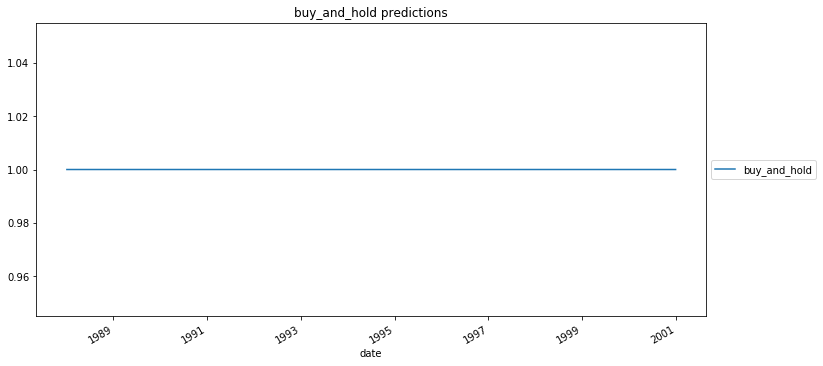

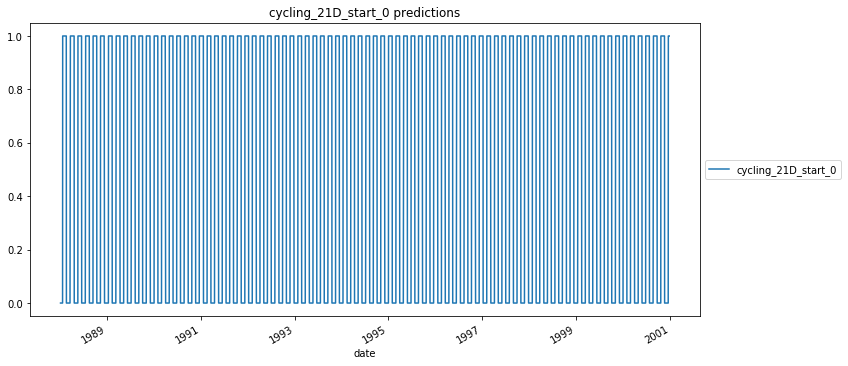

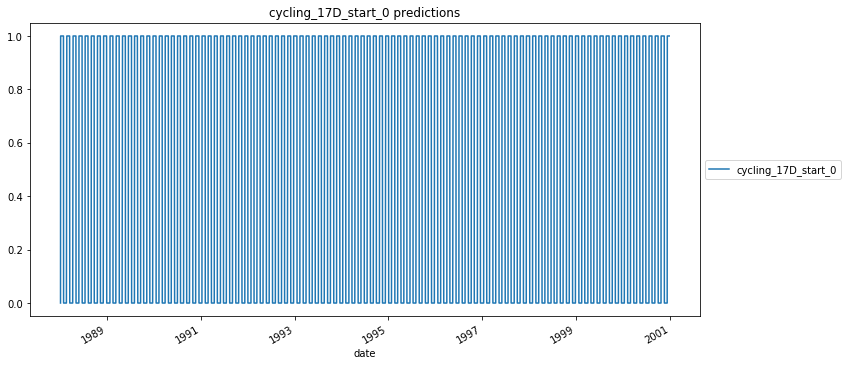

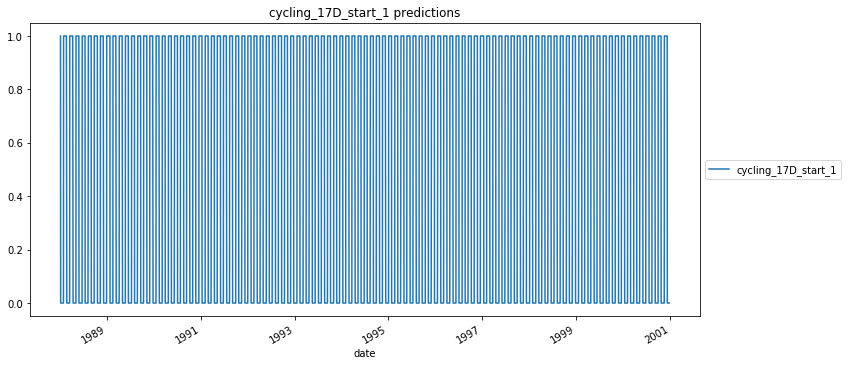

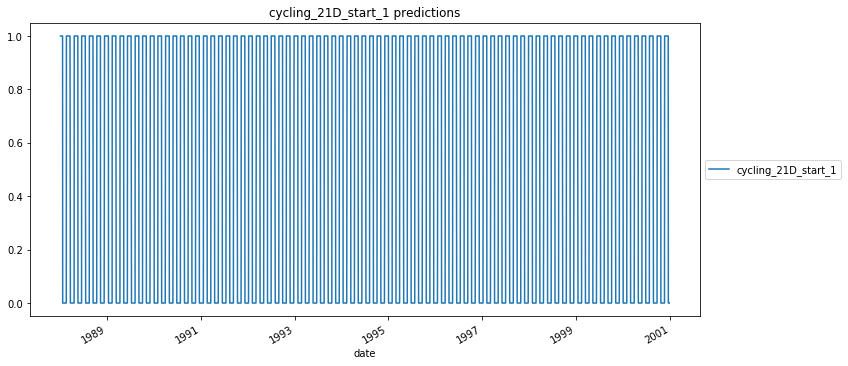

'2001-01-02 00:00:00 to 2011-12-30 00:00:00'

,highlight_ratio,flip_ratio,accu,prec,mse
cycling_21D_start_0,0.496508,0.057283,0.485684,0.529536,1.262939
cycling_17D_start_0,0.496508,0.066015,0.499651,0.543601,1.241596
cycling_17D_start_1,0.493715,0.067412,0.490573,0.534653,1.264337
cycling_21D_start_1,0.493715,0.055187,0.504539,0.548798,1.242994


,annual_return,sharpe_ratio,max_drawdown,avg_drawdown,return/avgdd
buy_and_hold,0.166255,0.914087,-0.290117,-0.057719,2.880430
cycling_21D_start_0,0.063827,0.528688,-0.297598,-0.062429,1.022381
cycling_17D_start_0,0.098826,0.791536,-0.268062,-0.052005,1.900302
cycling_17D_start_1,0.061365,0.506939,-0.214013,-0.069077,0.888352
cycling_21D_start_1,0.096283,0.765437,-0.197089,-0.046001,2.093063


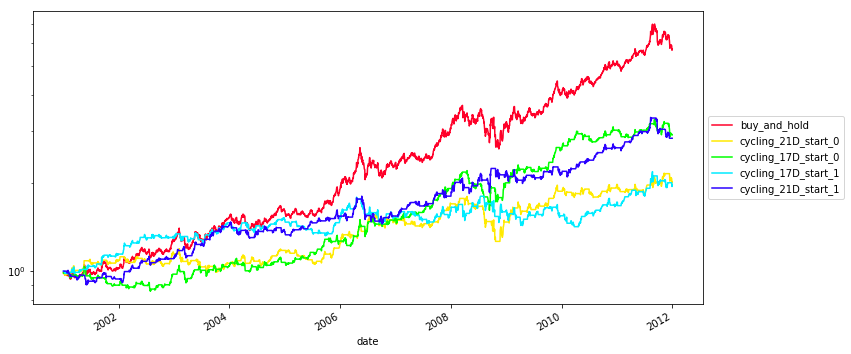

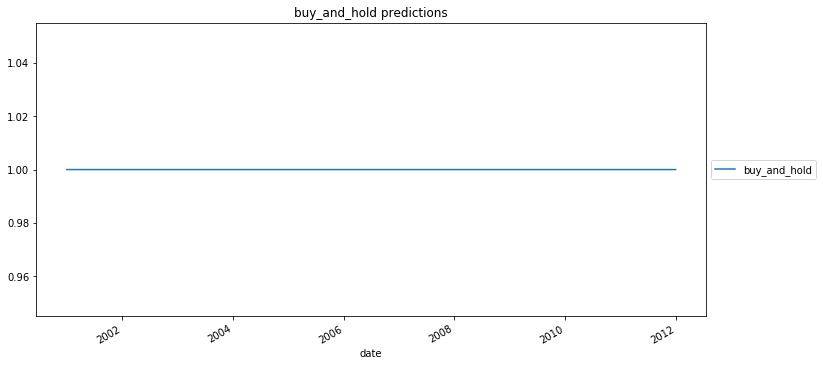

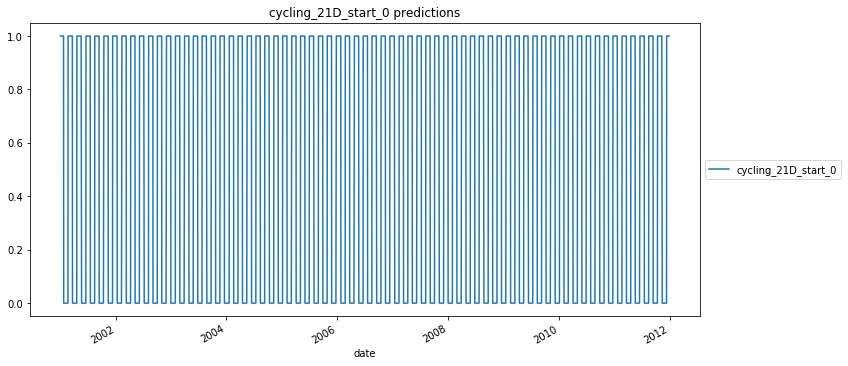

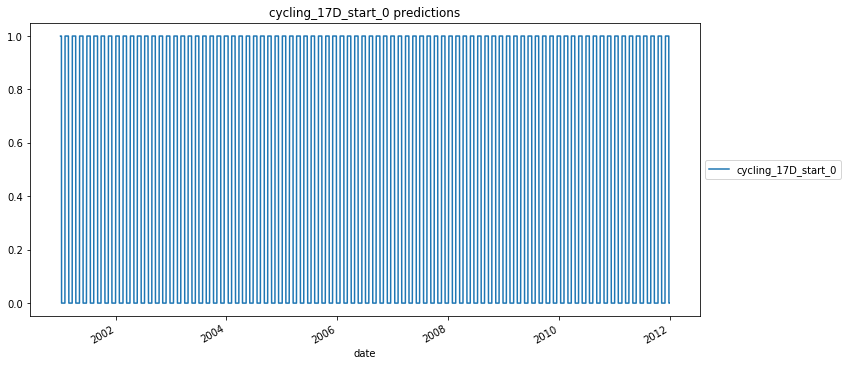

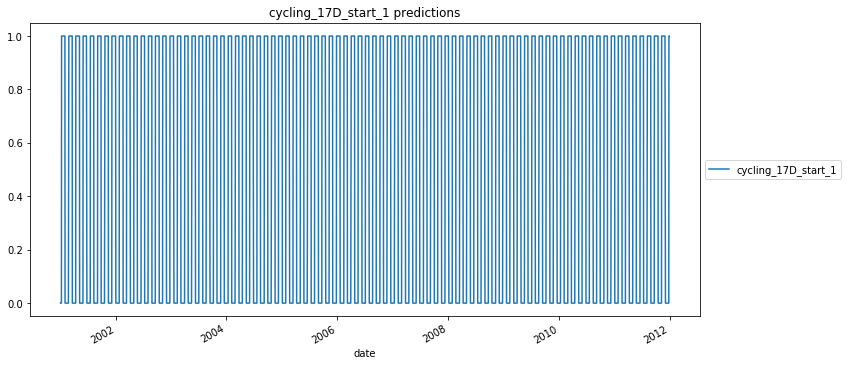

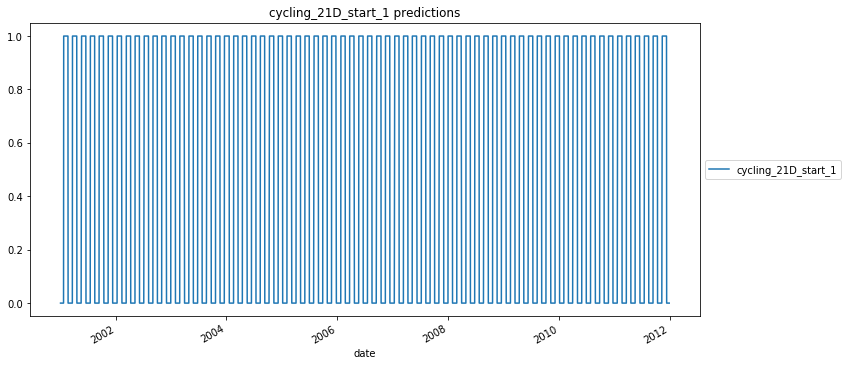

'2012-01-02 00:00:00 to 2015-12-31 00:00:00'

,highlight_ratio,flip_ratio,accu,prec,mse
cycling_21D_start_0,0.495202,0.049952,0.501919,0.486434,1.278521
cycling_17D_start_0,0.496161,0.060519,0.504798,0.489362,1.229703
cycling_17D_start_1,0.502879,0.058598,0.494242,0.479008,1.270320
cycling_21D_start_1,0.503839,0.048031,0.497121,0.481905,1.221502


,annual_return,sharpe_ratio,max_drawdown,avg_drawdown,return/avgdd
buy_and_hold,-0.089555,-0.494734,-0.412616,-0.229167,-0.390783
cycling_21D_start_0,-0.081030,-0.636223,-0.357086,-0.208265,-0.389073
cycling_17D_start_0,-0.020867,-0.118351,-0.252487,-0.090509,-0.230553
cycling_17D_start_1,-0.070151,-0.595862,-0.355436,-0.183569,-0.382153
cycling_21D_start_1,-0.009276,-0.031575,-0.179171,-0.068201,-0.136013


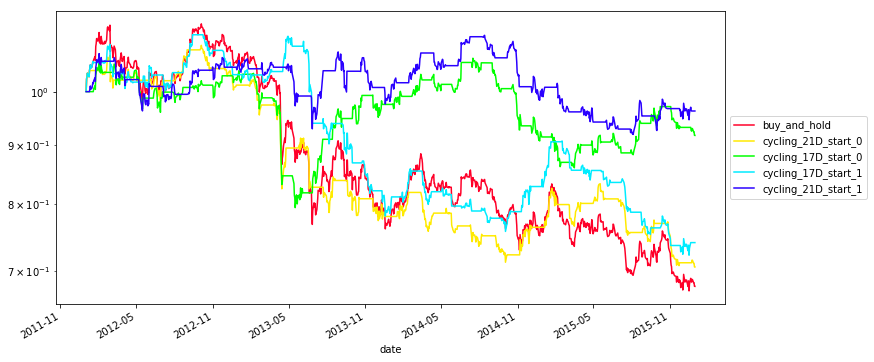

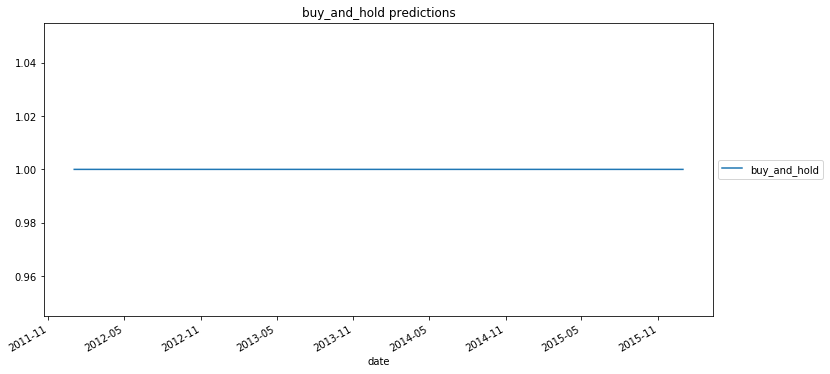

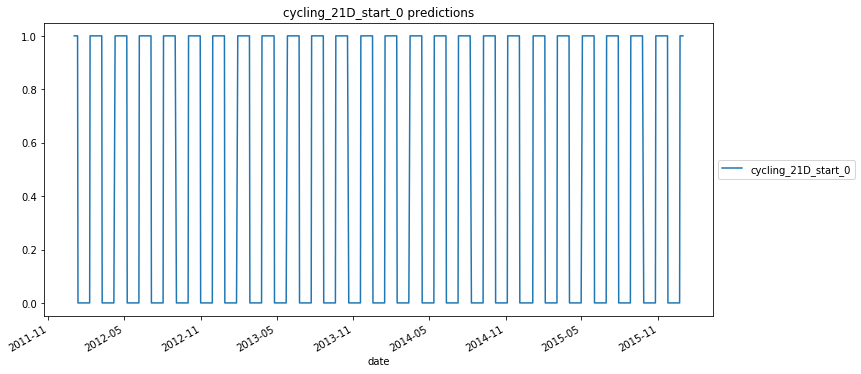

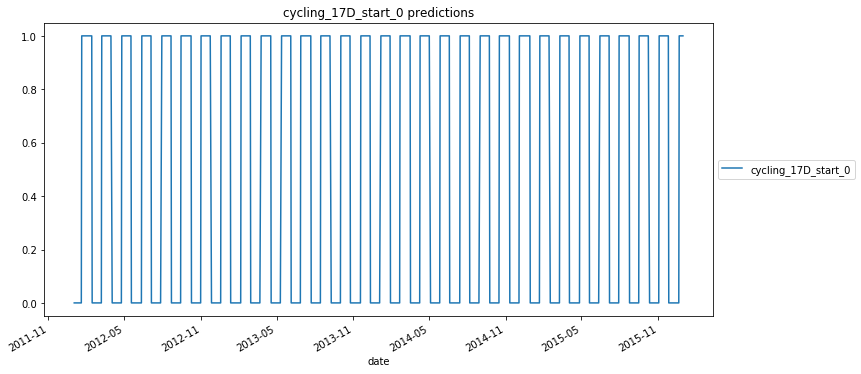

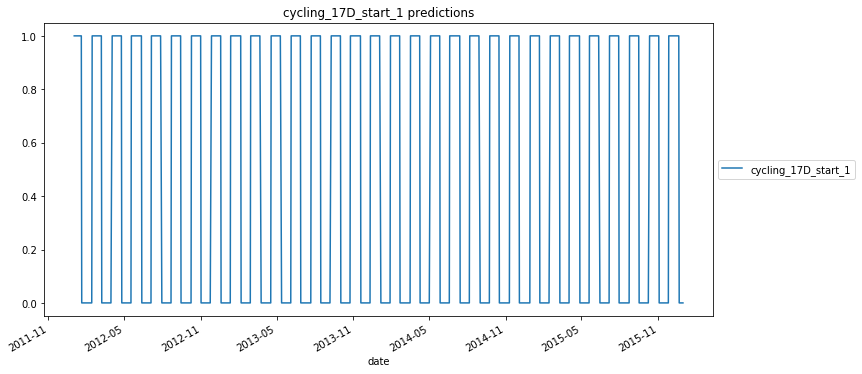

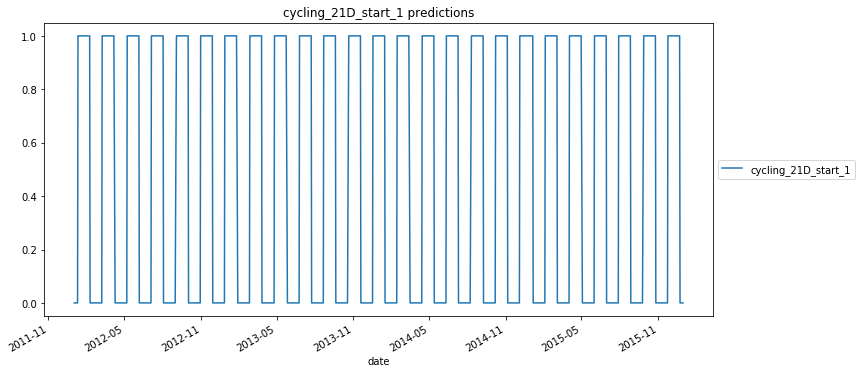

'2016-01-01 00:00:00 to 2021-12-31 00:00:00'

,highlight_ratio,flip_ratio,accu,prec,mse
cycling_21D_start_0,0.502879,0.047375,0.517594,0.553435,1.254227
cycling_17D_start_0,0.499680,0.058899,0.479846,0.516005,1.304089
cycling_17D_start_1,0.500320,0.058899,0.520154,0.556266,1.198723
cycling_21D_start_1,0.497121,0.047375,0.482406,0.518662,1.248585


,annual_return,sharpe_ratio,max_drawdown,avg_drawdown,return/avgdd
buy_and_hold,0.091659,0.718013,-0.185126,-0.066784,1.372467
cycling_21D_start_0,0.041749,0.479194,-0.160960,-0.061355,0.680440
cycling_17D_start_0,-0.012283,-0.085270,-0.265768,-0.131126,-0.093672
cycling_17D_start_1,0.105235,1.079397,-0.112651,-0.030274,3.476048
cycling_21D_start_1,0.047910,0.535342,-0.147966,-0.040883,1.171882


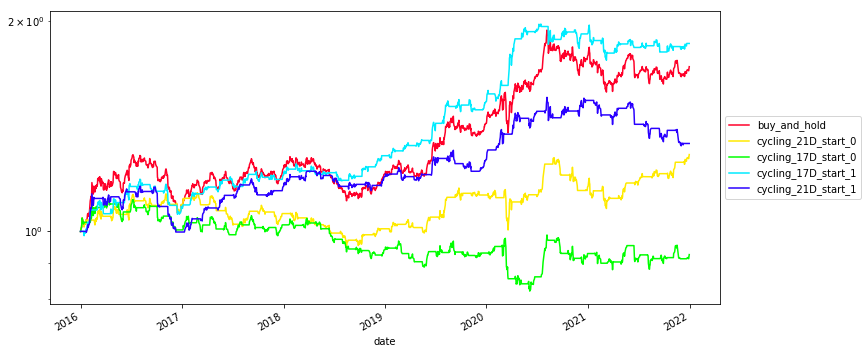

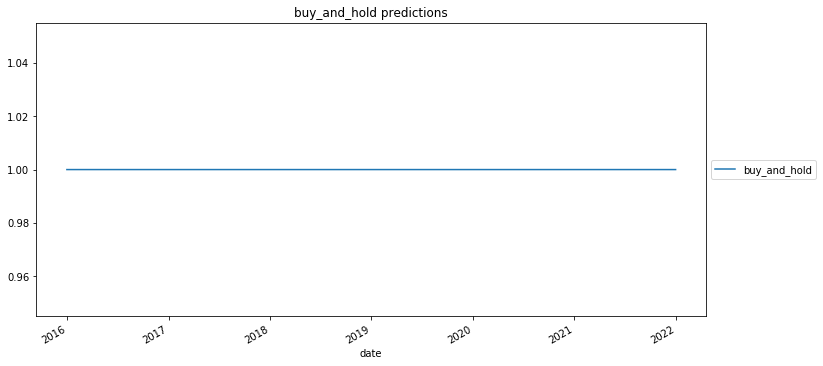

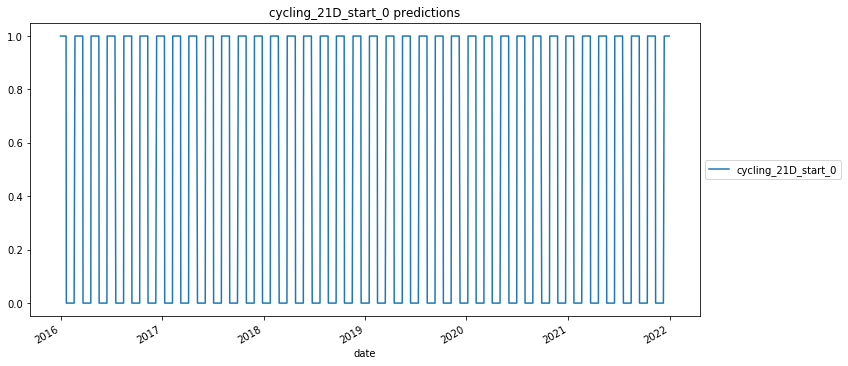

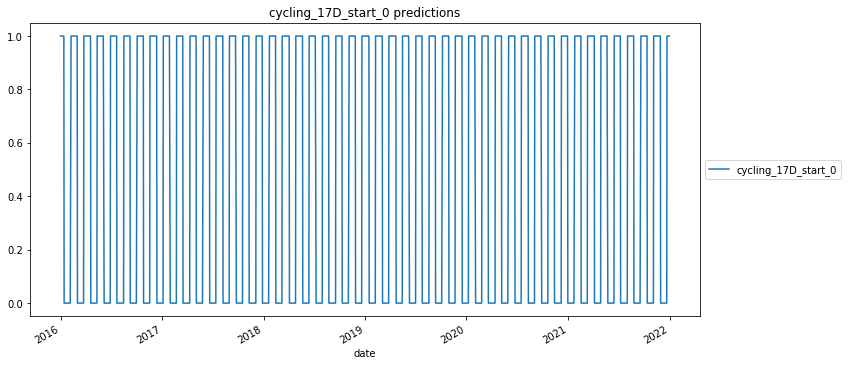

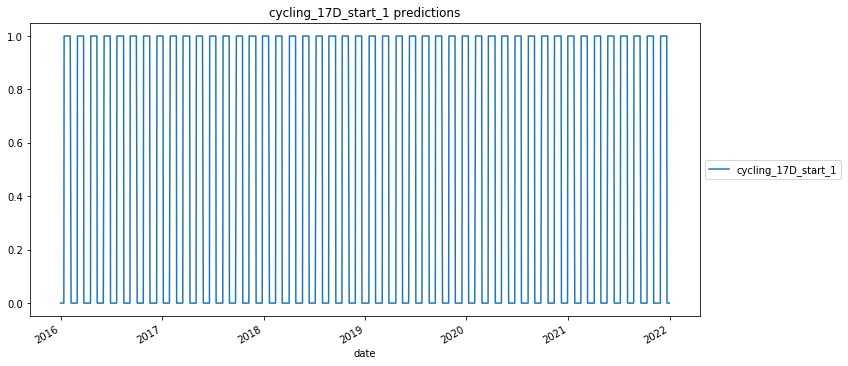

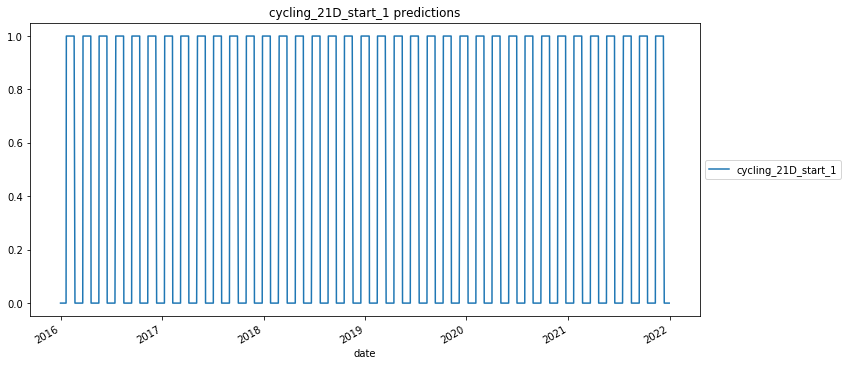

['buy_and_hold',
 'cycling_21D_start_0',
 'cycling_17D_start_0',
 'cycling_17D_start_1',
 'cycling_21D_start_1']

In [34]:
strategy_list_sel = print_all_result(ret_cycle, cycle_preds, sortby='sharpe_ratio')#, topn='buy_and_hold'

print_all_result(ret_cycle['1988':'2000'], cycle_preds, sortby='sharpe_ratio', strategy_list_sel=strategy_list_sel)
print_all_result(ret_cycle['2001':'2011'], cycle_preds, sortby='sharpe_ratio', strategy_list_sel=strategy_list_sel)
print_all_result(ret_cycle['2012':'2015'], cycle_preds, sortby='sharpe_ratio', strategy_list_sel=strategy_list_sel)
print_all_result(ret_cycle['2016':'2021'], cycle_preds, sortby='sharpe_ratio', strategy_list_sel=strategy_list_sel)

'1985-01-02 00:00:00 to 2021-12-31 00:00:00'

,highlight_ratio,flip_ratio,accu,prec,mse
cycling_21D_start_0,0.493550,0.058579,0.493030,0.510118,1.263596
cycling_17D_start_0,0.493238,0.069400,0.490637,0.507699,1.258789
cycling_17D_start_1,0.493134,0.071273,0.495734,0.512869,1.242137
cycling_21D_start_1,0.492821,0.060452,0.493342,0.510450,1.237330


,annual_return,sharpe_ratio,max_drawdown,avg_drawdown,return/avgdd
buy_and_hold,0.047776,0.378081,-0.493126,-0.224901,0.212431
cycling_21D_start_0,0.006993,0.118372,-0.453355,-0.228851,0.030557
cycling_17D_start_0,0.013223,0.174808,-0.620421,-0.289876,0.045616
cycling_17D_start_1,0.034102,0.358828,-0.355436,-0.095012,0.358925
cycling_21D_start_1,0.040500,0.420275,-0.289186,-0.087438,0.463182


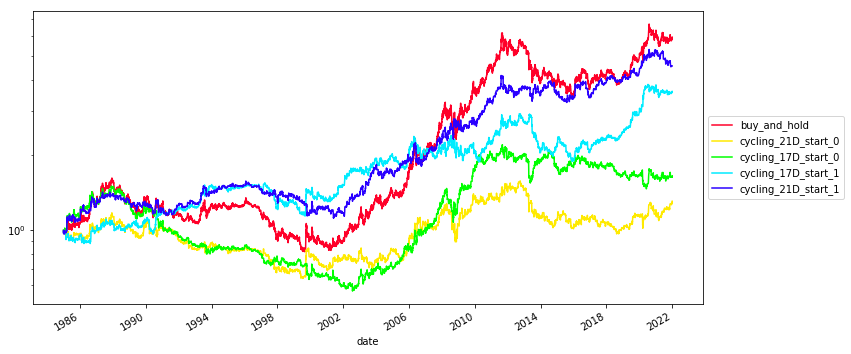

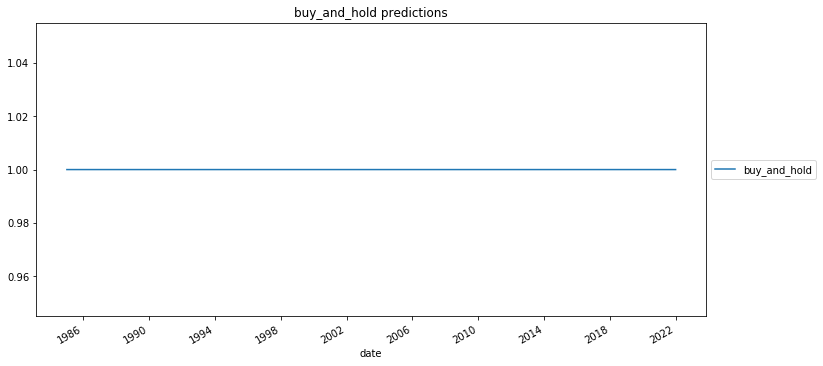

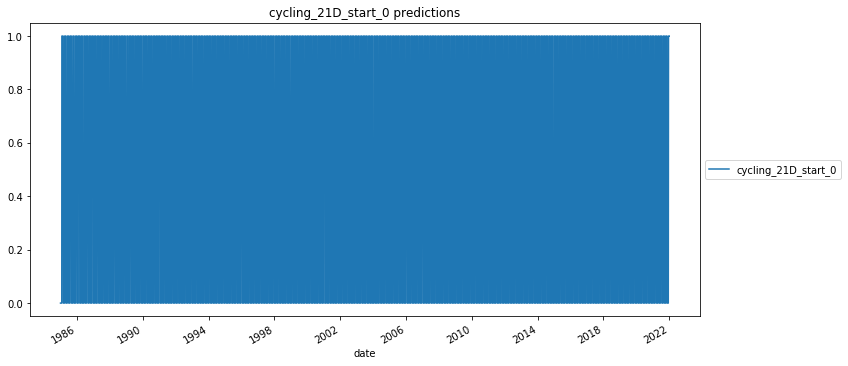

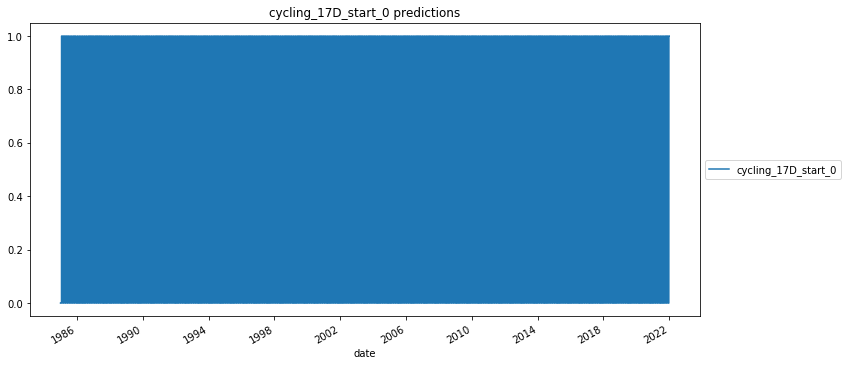

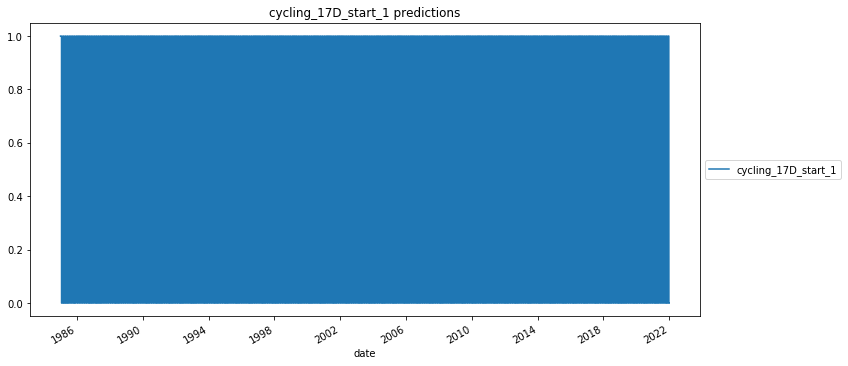

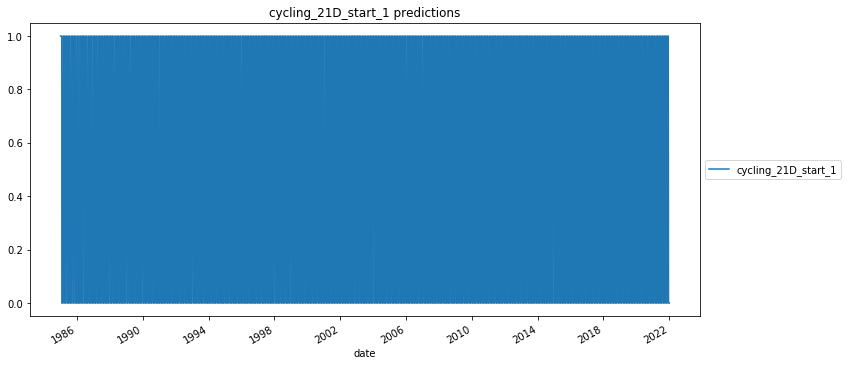

'1988-01-04 00:00:00 to 2000-12-29 00:00:00'

,highlight_ratio,flip_ratio,accu,prec,mse
cycling_21D_start_0,0.489198,0.064831,0.489494,0.476709,1.262938
cycling_17D_start_0,0.490382,0.077857,0.485351,0.472541,1.288412
cycling_17D_start_1,0.487126,0.079041,0.492157,0.479344,1.211636
cycling_21D_start_1,0.488310,0.070752,0.488014,0.475152,1.237110


,annual_return,sharpe_ratio,max_drawdown,avg_drawdown,return/avgdd
buy_and_hold,-0.042235,-0.283945,-0.481481,-0.272448,-0.155021
cycling_21D_start_0,-0.033970,-0.337314,-0.435026,-0.241526,-0.140649
cycling_17D_start_0,-0.057712,-0.642514,-0.576580,-0.390860,-0.147655
cycling_17D_start_1,0.016425,0.226499,-0.265479,-0.064452,0.254843
cycling_21D_start_1,-0.008555,-0.057282,-0.275052,-0.098676,-0.086703


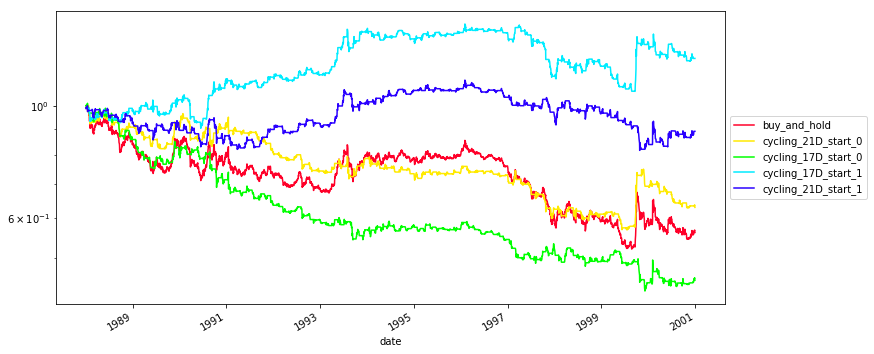

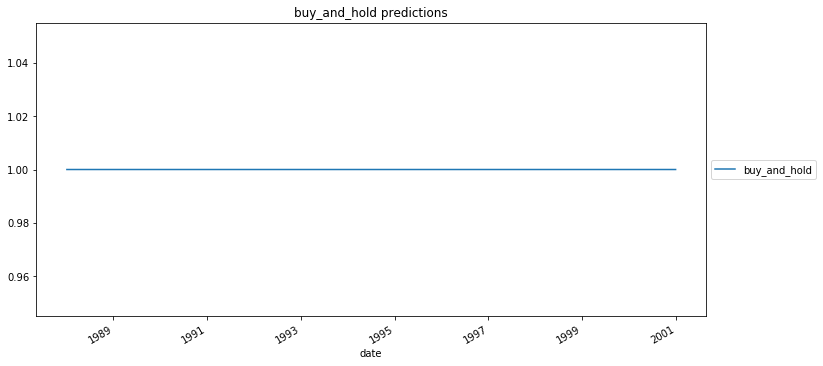

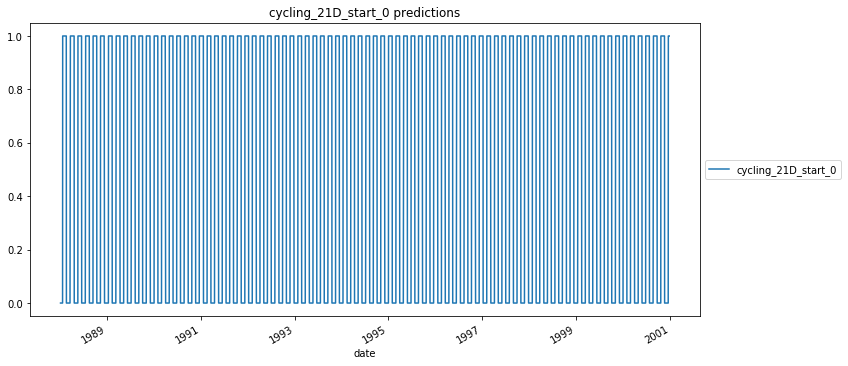

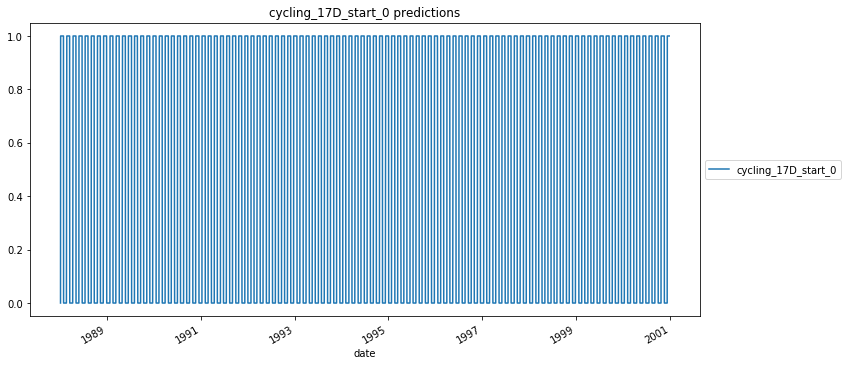

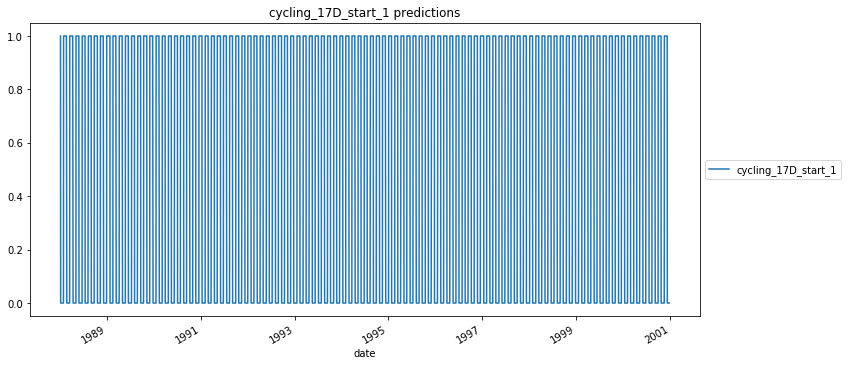

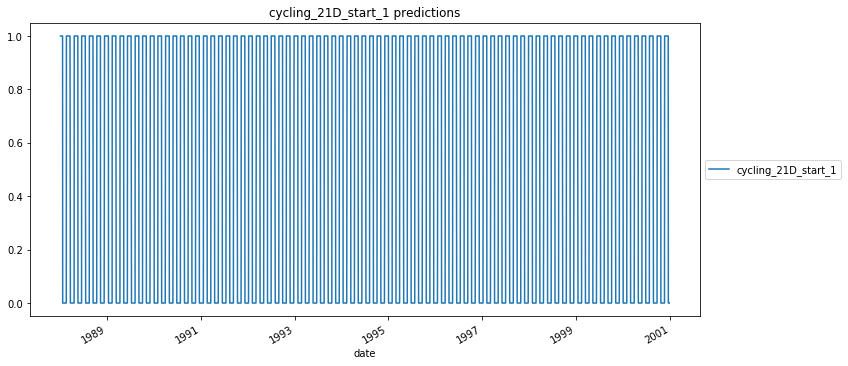

'2001-01-02 00:00:00 to 2011-12-30 00:00:00'

,highlight_ratio,flip_ratio,accu,prec,mse
cycling_21D_start_0,0.496508,0.057283,0.485684,0.529536,1.262939
cycling_17D_start_0,0.496508,0.066015,0.499651,0.543601,1.241596
cycling_17D_start_1,0.493715,0.067412,0.490573,0.534653,1.264337
cycling_21D_start_1,0.493715,0.055187,0.504539,0.548798,1.242994


,annual_return,sharpe_ratio,max_drawdown,avg_drawdown,return/avgdd
buy_and_hold,0.166255,0.914087,-0.290117,-0.057719,2.880430
cycling_21D_start_0,0.063827,0.528688,-0.297598,-0.062429,1.022381
cycling_17D_start_0,0.098826,0.791536,-0.268062,-0.052005,1.900302
cycling_17D_start_1,0.061365,0.506939,-0.214013,-0.069077,0.888352
cycling_21D_start_1,0.096283,0.765437,-0.197089,-0.046001,2.093063


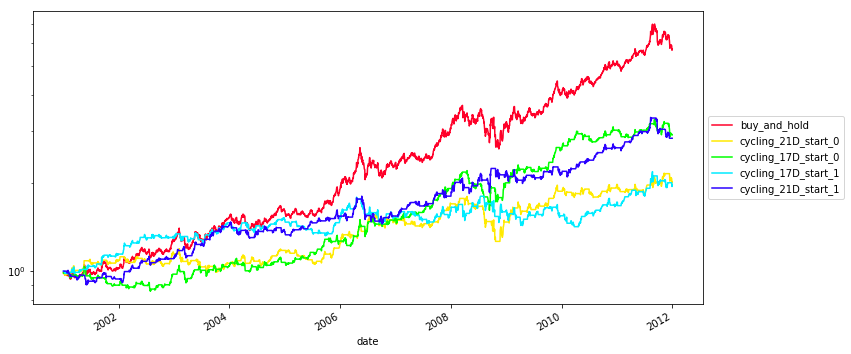

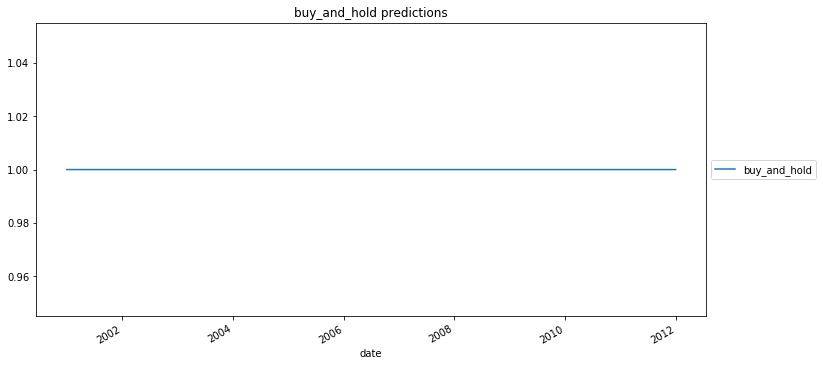

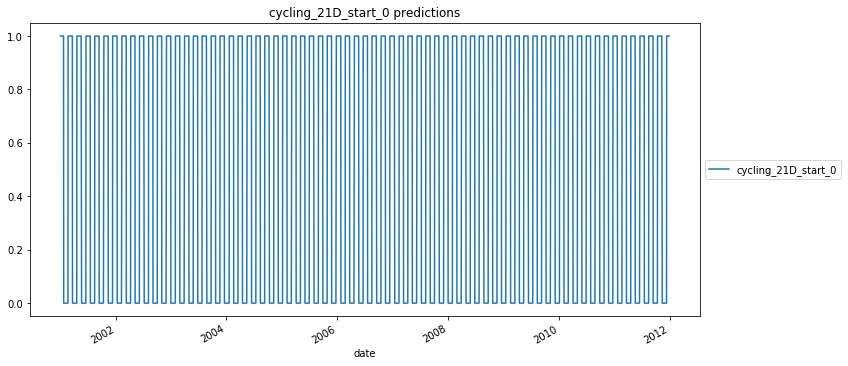

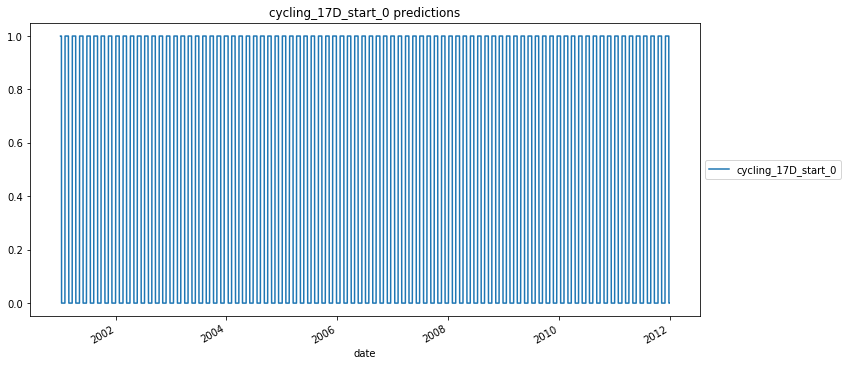

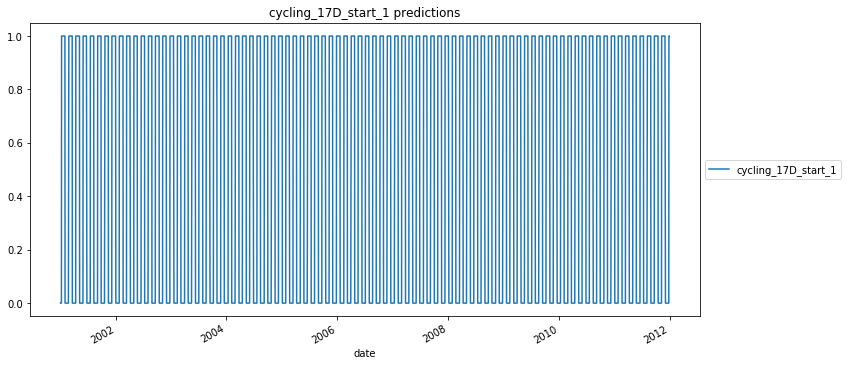

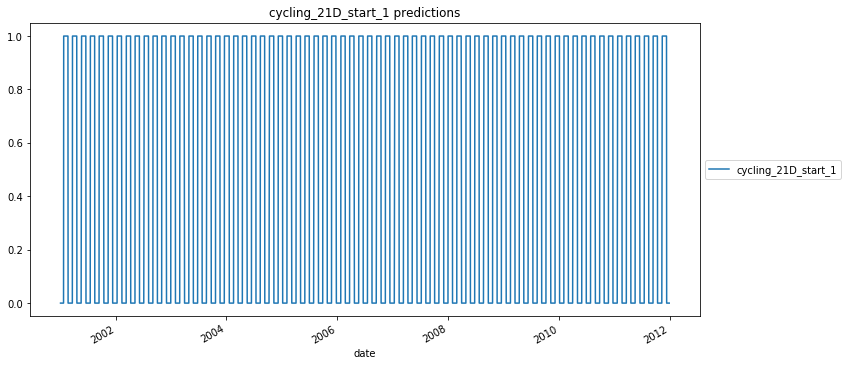

'2012-01-02 00:00:00 to 2015-12-31 00:00:00'

,highlight_ratio,flip_ratio,accu,prec,mse
cycling_21D_start_0,0.495202,0.049952,0.501919,0.486434,1.278521
cycling_17D_start_0,0.496161,0.060519,0.504798,0.489362,1.229703
cycling_17D_start_1,0.502879,0.058598,0.494242,0.479008,1.270320
cycling_21D_start_1,0.503839,0.048031,0.497121,0.481905,1.221502


,annual_return,sharpe_ratio,max_drawdown,avg_drawdown,return/avgdd
buy_and_hold,-0.089555,-0.494734,-0.412616,-0.229167,-0.390783
cycling_21D_start_0,-0.081030,-0.636223,-0.357086,-0.208265,-0.389073
cycling_17D_start_0,-0.020867,-0.118351,-0.252487,-0.090509,-0.230553
cycling_17D_start_1,-0.070151,-0.595862,-0.355436,-0.183569,-0.382153
cycling_21D_start_1,-0.009276,-0.031575,-0.179171,-0.068201,-0.136013


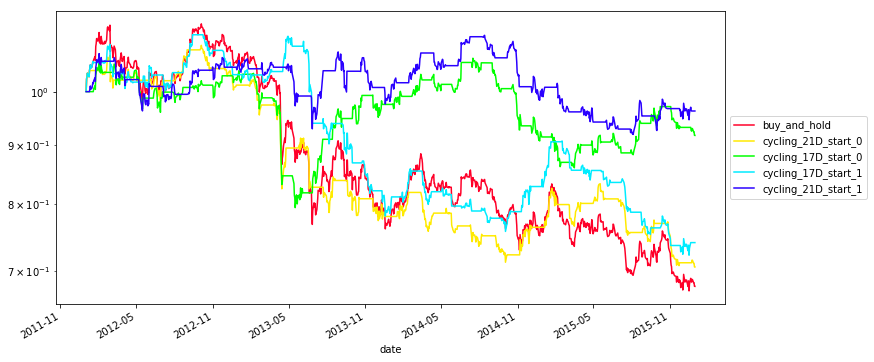

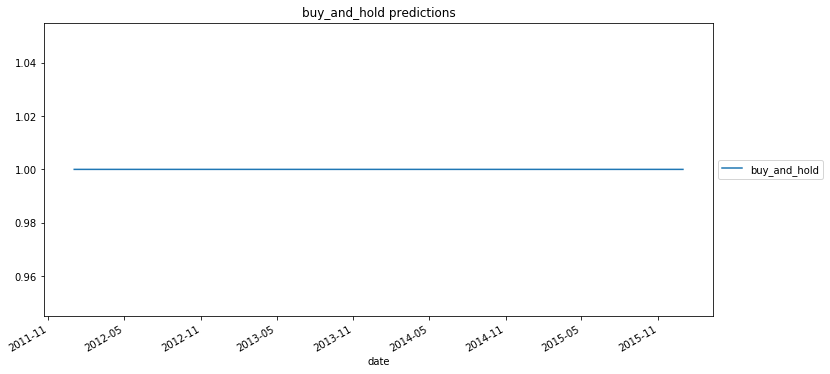

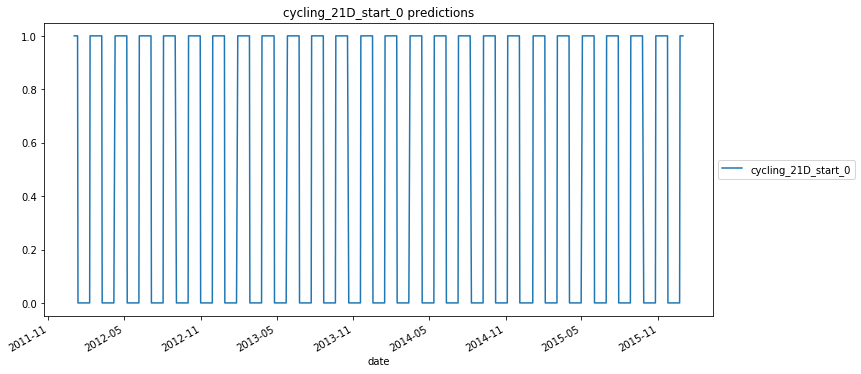

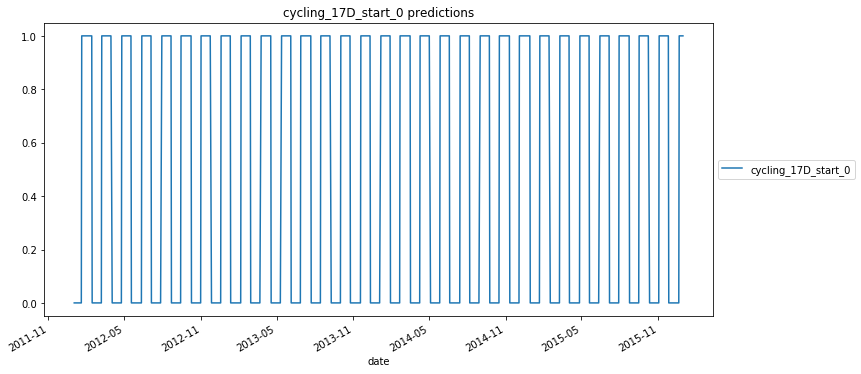

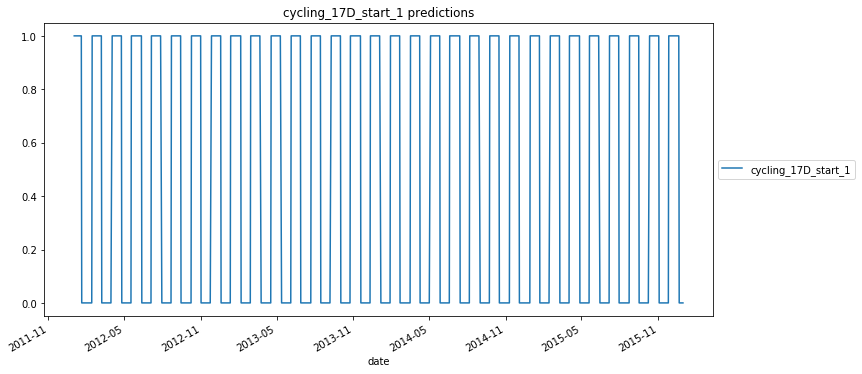

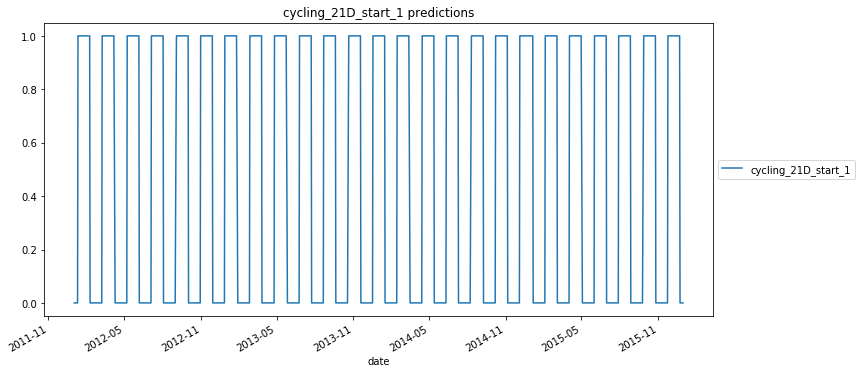

'2016-01-01 00:00:00 to 2021-12-31 00:00:00'

,highlight_ratio,flip_ratio,accu,prec,mse
cycling_21D_start_0,0.502879,0.047375,0.517594,0.553435,1.254227
cycling_17D_start_0,0.499680,0.058899,0.479846,0.516005,1.304089
cycling_17D_start_1,0.500320,0.058899,0.520154,0.556266,1.198723
cycling_21D_start_1,0.497121,0.047375,0.482406,0.518662,1.248585


,annual_return,sharpe_ratio,max_drawdown,avg_drawdown,return/avgdd
buy_and_hold,0.091659,0.718013,-0.185126,-0.066784,1.372467
cycling_21D_start_0,0.041749,0.479194,-0.160960,-0.061355,0.680440
cycling_17D_start_0,-0.012283,-0.085270,-0.265768,-0.131126,-0.093672
cycling_17D_start_1,0.105235,1.079397,-0.112651,-0.030274,3.476048
cycling_21D_start_1,0.047910,0.535342,-0.147966,-0.040883,1.171882


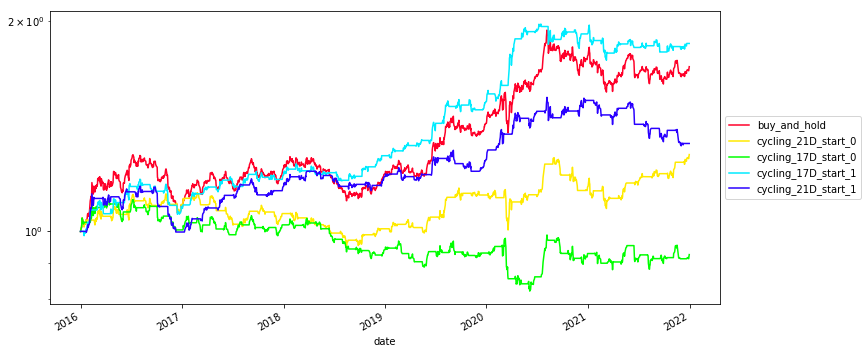

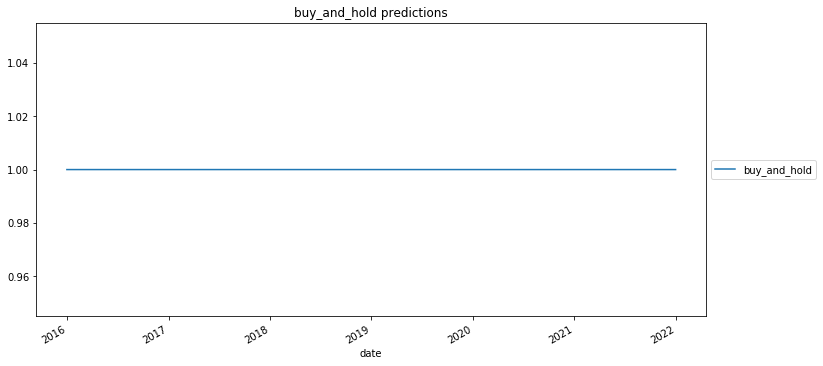

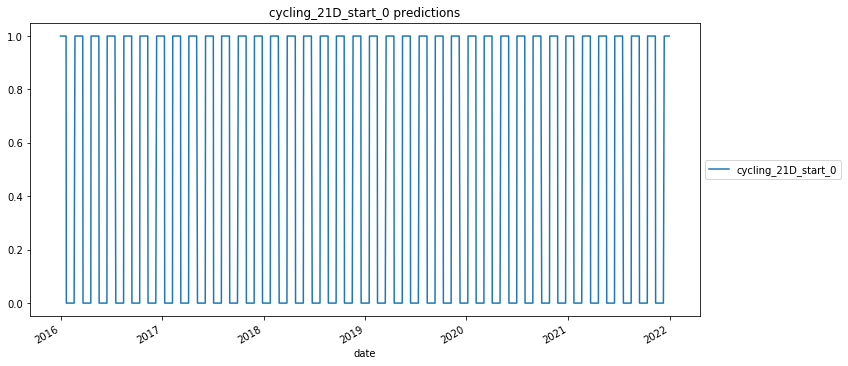

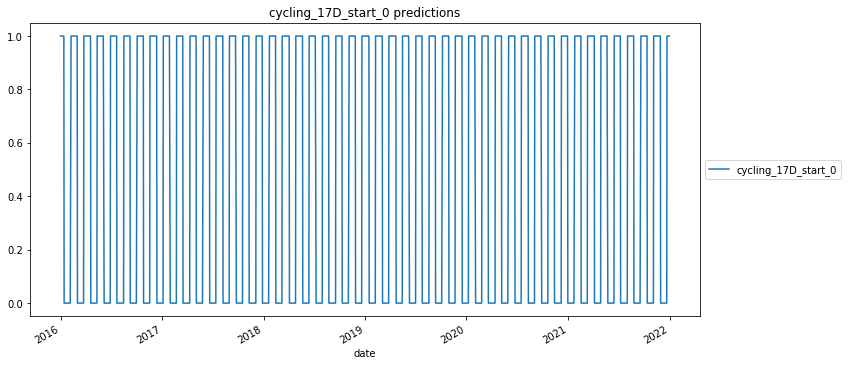

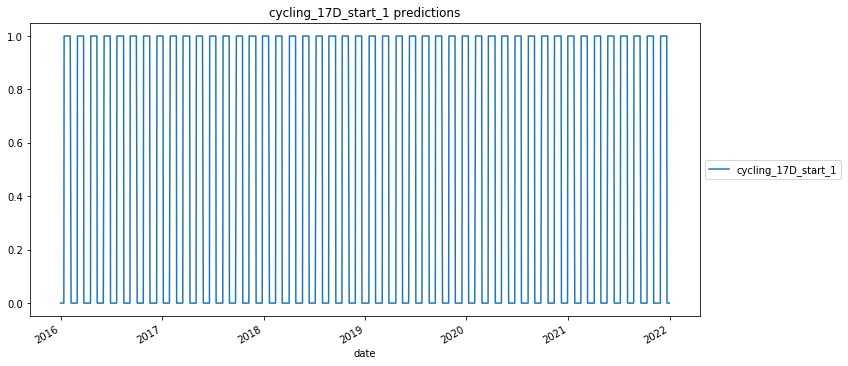

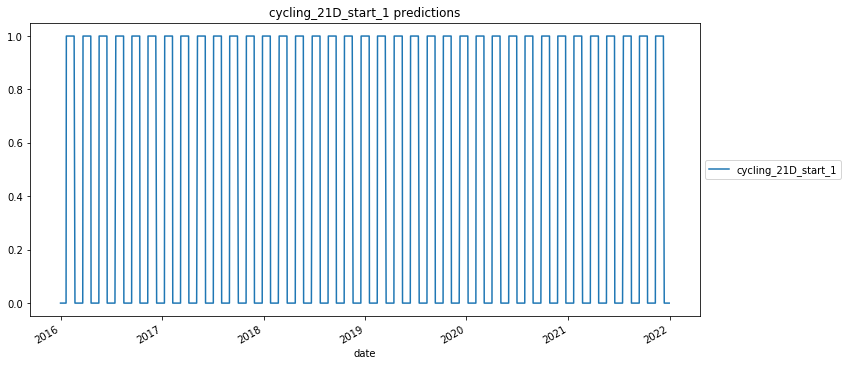

['buy_and_hold',
 'cycling_21D_start_0',
 'cycling_17D_start_0',
 'cycling_17D_start_1',
 'cycling_21D_start_1']

In [35]:
strategy_list_sel = print_all_result(ret_cycle, cycle_preds, sortby='return/avgdd')#, topn='buy_and_hold'

print_all_result(ret_cycle['1988':'2000'], cycle_preds, sortby='return/avgdd', strategy_list_sel=strategy_list_sel)
print_all_result(ret_cycle['2001':'2011'], cycle_preds, sortby='return/avgdd', strategy_list_sel=strategy_list_sel)
print_all_result(ret_cycle['2012':'2015'], cycle_preds, sortby='return/avgdd', strategy_list_sel=strategy_list_sel)
print_all_result(ret_cycle['2016':'2021'], cycle_preds, sortby='return/avgdd', strategy_list_sel=strategy_list_sel)

In [19]:
# cycle_preds.to_csv('cycling_preds/preds.csv')